# Tractably compute Maximum a Posteriori

Consider the case where we have $N$ binary variables $\mathbf{X}$ distributed according to uknown probability distribution $P(\mathbf{X})$ and a dataset $\mathcal{D}$ where datapoints are distributed according to $P(\mathbf{X})$.

For example, a point could be a binary vector from a multi-label classification task, representing whether an object is present on an image or not.

Using circuits, we can learn the distribution $P(\mathbf{X})$ from the dataset. What if we want to know which is the most probable assignment? For instance, which is the combination of objects that is most-likely to appear in the image? What if we know that some objects are present in the image, and we want to know what other objects are also likely to be in the image?

Answering these queries means computing the Maximum a Posteriori (MAP) of the distribution $P(\mathbf{X})$, eventually conditioned on some evidence that we would like to predict. Computing MAP is generally hard, since we have exponentially many assignments that we need to check.

It is possible, however, to tractably compute MAP if we have a smooth, decomposable and deterministic circuit! Let's see how to do this in `cirkit`.

First, we create a dataset that follows our example. We will set $|\mathbf{X}| = 10$. Moreover, we make sure that $P(\mathbf{X})$ has a clear and distinguishible mode -- i.e. we model the distribution so that most of the probability mass lies on one specific variable, $\mathbf{x}_4$ in our case.

In [256]:
import torch.distributions as D

NUM_VARIABLES = 10
MOST_LIKELY_VARIABLE = 3 # counting from 0

# define a prior over our data
# we do so by randomly sampling a un-normalized prior vector
data_p = torch.rand(num_variables)

# manually increase the mass on our target variable
data_p[MOST_LIKELY_VARIABLE] = 1.5
# normalize prior to obtain a valid probability distribution
data_p = data_p / data_p.sum()

Let's draw some samples from our distribution. We set $P(\mathbf{X})$ to a Multinomial distribution with $N$ trials ans use the prior we just defined. When we draw a sample, we apply the indicator function $[P(\mathbf{x}) > 0]$ to binarize it.

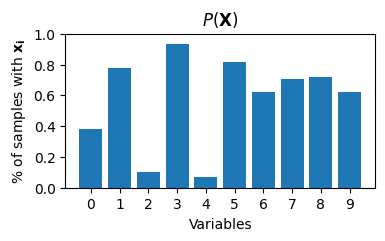

In [257]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

P_X = D.Multinomial(NUM_VARIABLES, probs=data_p).sample(sample_shape=torch.tensor([1000,])).bool().long()

fig, ax = plt.subplots(figsize=(4, 2))

count = P_X.sum(dim=0) / P_X.shape[0]

ax.bar([str(v) for v in range(num_variables)], count)
ax.set_xlabel("Variables")
ax.set_ylabel(r"% of samples with $\mathbf{x_i}$")
ax.set_title(r"$P(\mathbf{X})$")
ax.set_ylim(0, 1)

plt.show()

We can now fit this distribution using a circuit. To do so, we will build a fully factorized deterministic circuit over all the variables.

In [258]:
import sys
sys.path.insert(0, "../")

from cirkit.templates.pgms import deterministic_fully_factorized
import torch
from cirkit.pipeline import PipelineContext

device = "cuda:0"

# construct the symbolic circuit
s_circuit = deterministic_fully_factorized(NUM_VARIABLES)

# compile it to a torch computational graph
ctx = PipelineContext(backend="torch", semiring="lse-sum", fold=True, optimize=True)
circuit = ctx.compile(s_circuit).to(device)

# sanity check
sanity_state = torch.randint(2, size=(1, num_variables), device=device)
ll = circuit(sanity_state)
print(f"LL({sanity_state.tolist()}) = {ll.item():.2e}")

LL([[1, 0, 1, 0, 0, 1, 0, 0, 0, 1]]) = -6.67e+00


And train the circuit on our dataset by MLE.

In [259]:
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

dataset = TensorDataset(P_X)
dataloader = DataLoader(dataset, shuffle=True, batch_size=256)

num_epochs = 200
running_loss = 0
optimizer = optim.Adam(circuit.parameters(), lr=0.1)

for epoch_idx in range(num_epochs):
    for i, (batch,) in enumerate(dataloader):
        # Compute the log-likelihoods of the batch, by evaluating the circuit
        log_likelihoods = circuit(batch.to(device))

        # We take the negated average log-likelihood as loss
        loss = -torch.mean(log_likelihoods)
        loss.backward()
        # Update the parameters of the circuits, as any other model in PyTorch
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss * len(batch)


    if (epoch_idx % 50) == 0:
        print(f"Loss: {running_loss / len(dataset)}")
    running_loss = 0

Loss: 9.298686981201172
Loss: 5.0337300300598145
Loss: 5.0323333740234375
Loss: 5.035112380981445


We can compute the MAP state using brute-force -- i.e. we enumerate all the possible variable assignments and take the one with maximum likelihood.

In [260]:
from itertools import product

assignments = torch.tensor(list(product(*([[0, 1]] * num_variables))), device=device)
assignments_l = circuit(assignments)

# take the assignment with maximum likelihood
map_state = assignments[assignments_l.argmax()]

print("MAP state:", map_state.tolist())

MAP state: [0, 1, 0, 1, 0, 1, 1, 1, 1, 1]


or more efficiently, we can do obtain the same state in linear time by running a map query.

In [261]:
from cirkit.backend.torch.queries import MAPQuery

map_query = MAPQuery(circuit)
_, map_state = map_query()
print("MAP state:", map_state[0].tolist())

MAP state: [0, 1, 0, 1, 0, 1, 1, 1, 1, 1]


We can also provide evidences and compute the MAP state with respect to those evidence in `cirkit`

In [ ]:
# specify evidence: set the first variable to true
e = torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device=device)

# specify that only the first variable should be considered as evidence
# the other entries in the tensor can be ignored
is_evidence = torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device=device).bool()
map_value, map_state = map_query(x=e, evidence_vars=is_evidence)

print("MAP state:", map_state[0].tolist())

MAP state: [1, 1, 0, 1, 0, 1, 1, 1, 1, 1]


#### Approximate MAP

Notice that the circuit does not achieve a very good negative log likelihood. This is because determinism reduces the expressivity of the PC. We can overcome this limitation by overparameterizing the circuit. We will still be able to use the same algorithm to compute MAP, but we will obtain an approximation instead of an exact solution.

Let's see how good the approximation by building an overparameterized deep fully factorized circuit

In [265]:
from cirkit.templates.pgms import overparameterized_deep_fully_factorized

# construct the overparameterized symbolic circuit
s_circuit = overparameterized_deep_fully_factorized(NUM_VARIABLES, num_units=64)
# compile it to a torch computational graph
circuit = ctx.compile(s_circuit).to(device)

# sanity check
sanity_state = torch.randint(2, size=(1, num_variables), device=device)
ll = circuit(sanity_state)
print(f"LL({sanity_state.tolist()}) = {ll.item():.2e}")

LL([[1, 0, 0, 1, 0, 0, 1, 1, 1, 1]]) = -6.90e+00


and train it using MLE

In [266]:
running_loss = 0
optimizer = optim.Adam(circuit.parameters(), lr=0.1)
for epoch_idx in range(num_epochs):
    for i, (batch,) in enumerate(dataloader):
        # Compute the log-likelihoods of the batch, by evaluating the circuit
        log_likelihoods = circuit(batch.to(device))

        # We take the negated average log-likelihood as loss
        loss = -torch.mean(log_likelihoods)
        loss.backward()
        # Update the parameters of the circuits, as any other model in PyTorch
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss * len(batch)


    if (epoch_idx % 50) == 0:
        print(f"Loss: {running_loss / len(dataset)}")
    running_loss = 0

Loss: 6.3580498695373535
Loss: 4.985505104064941
Loss: 4.885632038116455
Loss: 4.823204517364502


Overparameterizing improves the negative log likelihood. But how close is the approximation?

In [267]:
assignments = torch.tensor(list(product(*([[0, 1]] * num_variables))), device=device)
assignments_l = circuit(assignments)

# take the assignment with maximum likelihood
map_state = assignments[assignments_l.argmax()]

print("Exact MAP state:", map_state.tolist())

Exact MAP state: [0, 1, 0, 1, 0, 1, 1, 1, 1, 0]


In [268]:
from cirkit.backend.torch.queries import MAPQuery

map_query = MAPQuery(circuit)
map_value, map_state = map_query()
print("Approximate MAP state:", map_state[0].tolist())

Approximate MAP state: [1, 1, 0, 1, 0, 1, 0, 1, 1, 1]


Indeed, the MAP state is different from the exact MAP state. Intuitively, determinism constrains the circuit to make unambigous decisions on the value of a variable. When it is removed, we might make decisions that are locally optimal but end up in a state that is not globally optimal.

Given the expressivity loss, approximate MAP is the best we can do if we want to model complex datasets. On our simple synthetic case the difference is noticeable but what about more complex, real-world looking domain?

For instance, let's try to model a simplified version of MNIST, where we down-scale images to $7 \times 7$ images. In this way, we can use a smaller PC which is faster to train.

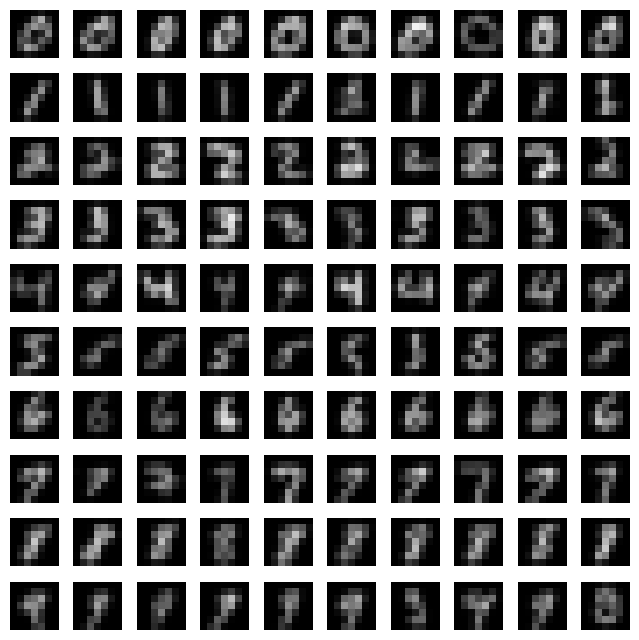

In [295]:
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# Load the MNIST data set and rescale images
transform = transforms.Compose([
    # resize to 5x5
    transforms.Resize((7, 7)),
    transforms.ToTensor(),
    # Flatten the images and set pixel values in the [0-255] range
    transforms.Lambda(lambda x: (255 * x.view(-1)).long())
])
data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)


fig, axs = plt.subplots(10, 10, figsize=(6.5, 6.5))

for i in range(10):
    i_targets = torch.where(data_train.targets == i)[0]

    for j in range(10):
        axs[i, j].imshow(data_train[i_targets[j].item()][0].detach().cpu().numpy().reshape(7, 7), cmap="grey", vmin=0, vmax=255)
        axs[i, j].axis("off")

fig.tight_layout()

We will construct the circuit as a QuadGraph and overparameterize it with $64$ units for each sum and each input.

In [337]:
from cirkit.templates import data_modalities, utils

# construct the quad graph circuit
symbolic_circuit = data_modalities.image_data(
    (1, 7, 7),                  
    region_graph='quad-graph',  
    input_layer='categorical',  
    num_input_units=64,         
    sum_product_layer='cp',     
    num_sum_units=64,           
    sum_weight_param=utils.Parameterization(activation='softmax', initialization='normal')
)

# compile it as usual
# NOTE: using compiler's optimization is not implemented yet for MAP
ctx = PipelineContext(semiring="lse-sum", fold=True)
circuit = ctx.compile(symbolic_circuit).to(device)

print(f"{(sum(p.numel() for p in circuit.parameters()) / 1e6):.2f}M trainable parameters")

1.54M trainable parameters


As usual, we learn the data by MLE

In [318]:
# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Initialize a torch optimizer of your choice,
#  e.g., Adam, by passing the parameters of the circuit
optimizer = optim.Adam(circuit.parameters(), lr=0.1)

num_epochs = 10
step_idx = 0
running_loss = 0.0
running_samples = 0

# Move the circuit to chosen device
circuit = circuit.to(device)

for epoch_idx in range(num_epochs):
    for i, (batch, _) in enumerate(train_dataloader):
        # The circuit expects an input of shape (batch_dim, num_variables)
        batch = batch.to(device)

        # Compute the log-likelihoods of the batch, by evaluating the circuit
        log_likelihoods = circuit(batch)

        # We take the negated average log-likelihood as loss
        loss = -1 * torch.mean(log_likelihoods)
        loss.backward()
        # Update the parameters of the circuits, as any other model in PyTorch
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.detach() * len(batch)
        running_samples += len(batch)
        step_idx += 1
        
    average_nll = running_loss / running_samples
    print(f"Epoch: {epoch_idx} | Average NLL: {average_nll}")
    running_loss = 0.0
    running_samples = 0

Epoch: 0 | Average NLL: 145.91893005371094
Epoch: 1 | Average NLL: 130.01303100585938
Epoch: 2 | Average NLL: 127.27069854736328
Epoch: 3 | Average NLL: 126.12313842773438
Epoch: 4 | Average NLL: 125.38375854492188
Epoch: 5 | Average NLL: 124.86088562011719
Epoch: 6 | Average NLL: 124.44892120361328
Epoch: 7 | Average NLL: 124.1292953491211
Epoch: 8 | Average NLL: 123.87117767333984
Epoch: 9 | Average NLL: 123.68338012695312


We will now exploit the circuit to reconstruct the images. We will erase half of the image and use the other half as evidence to the MAP query.
Notice that we take images from the **testing set**. The circuit never saw those images during training.

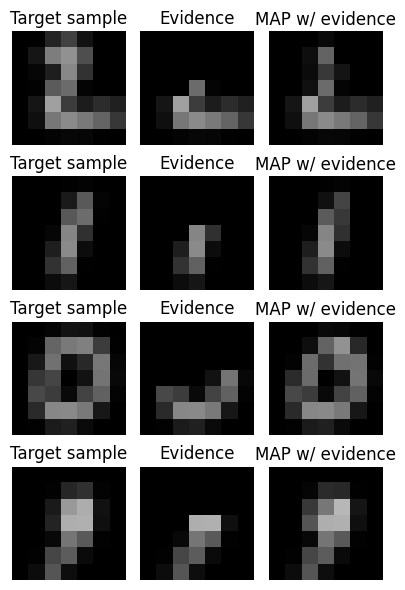

In [324]:
# For convenience, move the circuit to cpu during inference
circuit = circuit.to("cpu")

# prepare the map query on the circuit
map_query = MAPQuery(circuit)
map_value, map_state = map_query()

# select the images to erase
sample_idxs = [1, 5, 10, 1000]
fig, axs = plt.subplots(len(sample_idxs), 3, figsize=(4, 1.5 * len(sample_idxs)))
for i, s_idx in enumerate(sample_idxs):
    # take images from the testing set
    sample = data_test[s_idx][0].unsqueeze(0)
    
    # select the variables used as evidence
    evidence_vars = torch.full_like(sample, 0)
    evidence_vars[:, sample.shape[1] // 2:] = 1
    evidence_vars = evidence_vars.bool()
    evidence = sample.clone()
    evidence[~evidence_vars] = 0

    axs[i, 0].set_title(f"Target sample")
    axs[i, 0].imshow(sample.detach().cpu().numpy().reshape(7, 7), cmap="grey", vmin=0, vmax=255)
    axs[i, 0].axis("off")

    axs[i, 1].set_title("Evidence")
    axs[i, 1].imshow(evidence.detach().cpu().numpy().reshape(7, 7), cmap="grey", vmin=0, vmax=255)
    axs[i, 1].axis("off")

    # compute the image reconstruction
    map_val, map_state = map_query(
        x=evidence.to(circuit.device), 
        evidence_vars=evidence_vars.bool().to(circuit.device)
    )

    axs[i, 2].set_title(f"MAP w/ evidence")
    axs[i, 2].imshow(map_state.detach().cpu().numpy().reshape(7, 7), cmap="grey", vmin=0, vmax=255)
    axs[i, 2].axis("off")

fig.tight_layout()

The reconstructions are surprisingly accurate for a model with only 1.5 Million parameters! Of course, using more expressive models (i.e. by using an higher number of parameters) could result in more accurate performances.